# Toy problem for quantum MLE paper
Aditi and Stephen, May 2025

solve the problem $\min_x f(x)$ s.t. $x+y \le 1$ and nonnegative,
where
$$f(x)=-\log(ax+by) - \log(cx+dy) + \lambda(x+y)$$
for either $\lambda=0$ (and keep the constriants) or $\lambda=2$. With $\lambda=2$, you can sometimes drop the constraints if they were active and if the nonnegativity constraints were not active.

To find the optimal points, set gradient equal to zero
$$0=\nabla f(x) = \begin{bmatrix}
-\frac{a}{ax+by} - \frac{c}{cx+dy} + \lambda \\
-\frac{b}{ax+by} - \frac{d}{cx+dy} + \lambda
\end{bmatrix}$$
so letting $w=ax+by$ and $u=cx+dy$, we can solve for $w$ and $u$ first, and then solve from those back to $x$ and $y$.

To do this, take the first equation and subtract $\frac{c}{d}$ times the second, to get
$$-2\left(1-\frac{d}{d}\right) = \frac{-a+\frac{c}{d}b}{w}$$

We get
$$w = \frac{-1}{\lambda}\frac{ \frac{cb}{d}-a}{\frac{d-c}{d}} = \frac{-1}{\lambda}\frac{cb-ad}{d-c}= \frac{1}{\lambda}\frac{\Delta}{d-c}$$
where $\Delta=ad-bc$.

Similarly, if we take the first equation and subtrace $\frac{a}{b}$ times the second one, and then solve for $u$, we get
$$u=\frac{-1}{\lambda}\frac{ad-bc}{b-a}= \frac{-1}{\lambda}\frac{\Delta}{b-a}.$$

Then we solve
$$\begin{bmatrix}a&b\\c&d\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix}
= \begin{bmatrix}w\\u\end{bmatrix}$$
i.e.,
$$\begin{bmatrix}x\\y\end{bmatrix} =\begin{bmatrix}a&b\\c&d\end{bmatrix}^{-1}
 \begin{bmatrix}w\\u\end{bmatrix}
 =\frac{1}{\Delta}\begin{bmatrix}d&-b\\-c&a\end{bmatrix}
 \begin{bmatrix}w\\u\end{bmatrix}
 =\frac{-1}{\lambda}\begin{bmatrix}
\frac{d}{c-d} - \frac{b}{b-a} \\ \frac{-c}{c-d} + \frac{a}{b-a}
 \end{bmatrix}
 $$
 and $\lambda=2$ if the constraint is active.

 To pick a problem, we want the main constraint to be active and avoid negative numbers.  If we define $\delta_1 = b-a$ and $\delta_2=c-d$ then we see that we want $\delta_1 \delta_2 >0$ (e.g., both are positive, so $b>a$ and $c>d$), and
 $$\frac{a}{\delta_1} > \frac{d}{\delta_2}.$$
 We also want something like $a\approx 1$ and $b\gg 1$ to make the Hessian ill-conditioned. Note: there are two terms in the Hessian. I found that at the optimal point, they are both ill-conditioned, but their sum is very well conditioned. However, at a nasty starting point, the sum is ill-conditioned.

 For reference, the Hessian for the first term is
 $$
 \frac{ab}{(ax+by)^2}\begin{bmatrix}a&1\\1&b\end{bmatrix}
 $$
 and similarly for the second term with $c,d$. To make it ill-conditioned, either take $a\approx b \approx 1$ so it is nearly reank deficient, or pick $a\approx 1$ and $b \gg 1$ so it has a very large eigenvalue.

In [ ]:
#!pip install brokenaxes

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
# from brokenaxes import brokenaxes

The following script runs the algorithms but it's very fast since it is 2D, so less than 10 seconds. Then we plot the results

In [ ]:
def projection(x,tau=1):
    """ project vector x onto the simplex sum(x) <= 1, x >= 0 """
    # as long as both x and y are not zero, should be OK
    x = x.copy()
    x[ x < 0 ] = 0
    r = x.sum()
    if r <= tau:
        return x
    else:
        x =  x - (r-tau)/x.size
        if x.min() <= 0:
            #print(f'Problem, set entry to less than 0')

            if x.max() <= 0:
                raise ValueError('cannot have both entries 0 or less')
            # Quick hack if it is dimension 2: one coordinate is zero-d out, so the other will be 1
            if x[0] > x[1]:
                x[0] = 1.
                x[1] = 0.
            else:
                x[0] = 0.
                x[1] = 1.
        return x
# x0    = np.array( [1,1])
def scaling(x,tau=1):
    """ scales so that sum(x) <= 1, x >= 0. Not a projection """
    x[ x < 0 ] = 0.  # project
    r = x.sum()
    if r > tau:
        x = x * tau / r
    return x

In [ ]:
# Setup the problem
a,b,c,d = 1.1, 1e4, 1e4, 1
A1 = np.array( [a,b] )
A2 = np.array( [c,d] )
lam   = 2

# Solve for answer
xTrue    = np.zeros(2)
xTrue[0] = -( d/(c-d)  - b/(b-a))/lam
xTrue[1] = -( -c/(c-d) + a/(b-a))/lam
with np.printoptions(precision=3):
    print('True solution is at:')
    print(xTrue)

errFcn = lambda x : norm(x-xTrue)

def f(x, lam=0):
    y = -np.log( np.dot(A1,x) ) - np.log( np.dot(A2,x) )
    if lam == 0:
        return y
    else:
        return y + lam*x.sum()
def gradf(x,lam=0):
    y = -A1/np.dot(A1,x) - A2/np.dot(A2,x)
    if lam == 0:
        return y
    else:
        return y + lam
def hessf(x,lam=0,debug=False):
    # lam has no effect since a linear term anyhow...
    Y = np.array( [[a**2,a*b],[a*b,b**2]] )/ (np.dot(A1,x)**2)
    if debug:
        print('Condition numbers of Hessian terms:')
        print(np.linalg.cond(Y))
        print(np.linalg.cond(np.array( [[c**2,c*d],[c*d,d**2]] )/ (np.dot(A2,x)**2)))
    Y += np.array( [[c**2,c*d],[c*d,d**2]] )/ (np.dot(A2,x)**2)
    if debug:
        # They are cancelling each other out!!
        print(np.linalg.cond(Y))
    return Y
with np.printoptions(precision=3):
    print('Gradient at true solution is:')
    print(gradf(xTrue,lam=lam))
    H = hessf(xTrue)
    print('Hessian at solution:')
    print(H)
    print(np.linalg.cond(H)) # hmm, very well conditioned!
    print('Hessian at another point')
    x0 = np.array( [.99,.01]) # Not nearly as well conditioned here
    H = hessf(x0)
    print(H)
    print(np.linalg.cond(H))

True solution is at:
[0.5 0.5]
Gradient at true solution is:
[0. 0.]
Hessian at solution:
[[3.999e+00 8.398e-04]
 [8.398e-04 3.999e+00]]
1.0004205645346518
Hessian at another point
[[1.020e+00 1.077e+00]
 [1.077e+00 9.786e+03]]
9590.991052024234


In [ ]:
def gradientDescent(stepsize,x0,maxits=100,tol=1e-15,lam=0,proj=None,printError=True, badTol = 1e5, keepPositive =False ):
    x = projection( x0.copy() )
    errHist = [errFcn(x)]
    if lam == 0 and proj is None:
        print('WARNING: no Lagrangian and no projection, you probably do not want to do that')
    for k in range(int(maxits)):
        if proj is None:
            x = x - stepsize*gradf(x, lam=lam )
            # if x.max() <= 0:
            #     # only seems to happen for large stepsizes, so that's good...
            #     print(f'Iter {k:4d}, stepsize {stepsize:.2e}, max value of x is {x.max():.3g}')
        else:
            g = gradf(x, lam=lam )
            if keepPositive:
                # crude linesearch. Assumes x >= 0
                t = x[ g > 0]/g[ g > 0 ]
                if t.size > 0:
                    t = t.max() # keeps at least one entry nonnegative
                    # t = t.min() # keeps all entries nonnegative
                    t *= .99 # keep it strictly positive
                else:
                    t = stepsize
            else:
                t = stepsize
            x = proj( x - t*g )
        if printError:
            print(f'Iter {k:3d}, error is {errFcn(x):.2e}')
        errHist.append( errFcn(x))
        if (errFcn(x) < tol) or (errFcn(x) > badTol):
            # catch convergence or divergence
            break
    return x, errHist

def findBestStepsize(stepsizeList,*args,**kwargs):
    bestSoFar = 1e100
    for stepsize in stepsizeList:
        x,errHist=gradientDescent(stepsize,*args,**kwargs)
        if errHist[-1] < bestSoFar:
            bestSoFar = errHist[-1]
            bestStepsize = stepsize
            bestX        = x
            bestErrHist  = errHist
    return bestX, bestErrHist, bestStepsize

## Collect data
Loop over all stepsizes

In [ ]:
LABELS = {'N':'Newton (unconstrained)','PN':'Projected Newton','SN':'Scaled Newton', 'GD':'Gradient descent (unconstrained)','PGD':'Projected gradient descent','SGD':'Scaled gradient descent'}
ERRORS = dict.fromkeys( LABELS.keys() )
STEPSIZES = dict.fromkeys( LABELS.keys() )

print('Newton method on Lagrangian')
x = projection( x0.copy() )
errHist = [errFcn(x)]
for k in range(12):
    x = x - np.linalg.solve( hessf(x,lam=lam), gradf(x, lam=lam ) )
    #print(f'Iter {k:3d}, error is {errFcn(x):.2e}')
    errHist.append( errFcn(x))
    if errFcn(x) < 1e-15:
        break
ERRORS['N'] = errHist

# And tried Newton with projection or scaling
maxits = int(1e3)

x = projection( x0.copy() )
errHist = [errFcn(x)]
for k in range(maxits):
    x = projection(x - np.linalg.solve( hessf(x), gradf(x) )) # no lam
    #print(f'Iter {k:3d}, error is {errFcn(x):.2e}')
    errHist.append( errFcn(x))
    if errFcn(x) < 1e-15:
        break
ERRORS['PN'] = errHist
x = scaling( x0.copy() )
errHist = [errFcn(x)]
for k in range(maxits):
    x = scaling(x - np.linalg.solve( hessf(x), gradf(x) )) # no lam
    #print(f'Iter {k:3d}, error is {errFcn(x):.2e}')
    errHist.append( errFcn(x))
    if errFcn(x) < 1e-15:
        break
ERRORS['SN'] = errHist


print('Now running loops for gradient descent methods to find best stepsizes')
stepsizeList = np.logspace(-5,2,100)


x,errHist,bestStepsize=findBestStepsize(stepsizeList,x0,lam=lam,printError=False,maxits = maxits)
ERRORS['GD'] = errHist
STEPSIZES['GD'] = bestStepsize

x,errHist,bestStepsize=findBestStepsize(stepsizeList,x0,proj=projection,printError=False,maxits = maxits)
ERRORS['PGD'] = errHist
STEPSIZES['PGD'] = bestStepsize

x,errHist,bestStepsize=findBestStepsize(stepsizeList,x0,proj=scaling,printError=False,maxits = maxits)
ERRORS['SGD'] = errHist
STEPSIZES['SGD'] = bestStepsize

Newton method on Lagrangian
Now running loops for gradient descent methods to find best stepsizes


In [ ]:
print(STEPSIZES)
print(x0)
print(xTrue)
print(a,b,c,d)

{'N': None, 'PN': None, 'SN': None, 'GD': np.float64(0.24201282647943834), 'PGD': np.float64(0.01291549665014884), 'SGD': np.float64(37.64935806792464)}
[0.99 0.01]
[0.500005 0.499995]
1.1 10000.0 10000.0 1


In [ ]:
# k = 'N'
# plt.semilogy( ERRORS[k],':',marker='o', label=LABELS[k],mfc='none')
# k = 'GD'
# plt.semilogy( ERRORS[k],'s:',label=LABELS[k],mfc='none')

# k = 'PN'
# plt.semilogy( ERRORS[k],'--',label=LABELS[k])
# k = 'SN'
# plt.semilogy( ERRORS[k],':',label=LABELS[k])

# k = 'PGD'
# plt.semilogy( ERRORS[k],'-.',label=LABELS[k])
# k = 'SGD'
# plt.semilogy( ERRORS[k],'-',label=LABELS[k])

# # plt.legend(loc=1)
# # plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# # plt.ylim(bottom=1e-17)
# plt.ylabel('Error')
# plt.xlabel('Iteration')
# plt.xscale('log')
# plt.show()

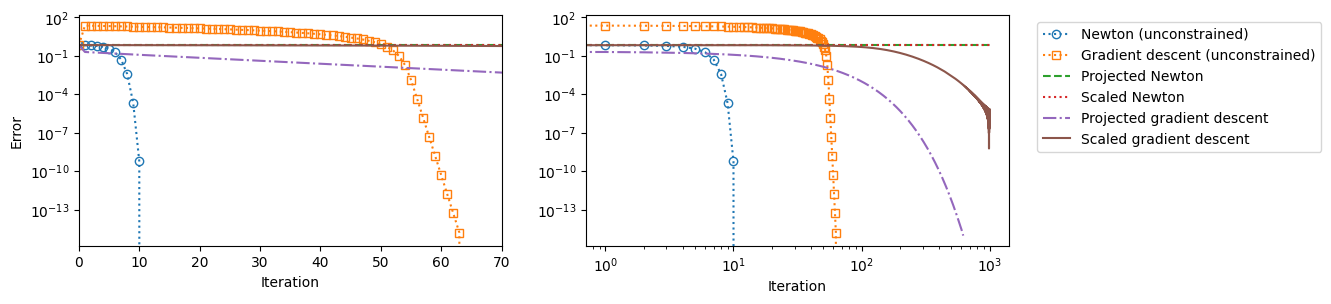

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,3))

for i in range(2):
  k = 'N'
  axs[i].semilogy( ERRORS[k],':',marker='o', label=LABELS[k],mfc='none')
  k = 'GD'
  axs[i].semilogy( ERRORS[k],'s:',label=LABELS[k],mfc='none')

  k = 'PN'
  axs[i].semilogy( ERRORS[k],'--',label=LABELS[k])
  k = 'SN'
  axs[i].semilogy( ERRORS[k],':',label=LABELS[k])

  k = 'PGD'
  axs[i].semilogy( ERRORS[k],'-.',label=LABELS[k])
  k = 'SGD'
  axs[i].semilogy( ERRORS[k],'-',label=LABELS[k])
  axs[i].set_xlabel('Iteration')

axs[0].set_xlim(left=0,right=70)
axs[1].set_xscale('log')

# Set labelsn')
axs[0].set_ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('toyExample.pdf',bbox_inches='tight')
plt.show()